In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import re
import string
import os
from collections import defaultdict
from collections import Counter

plt.style.use('ggplot')
stop = set(stopwords.words('english'))

import gensim
from tqdm.notebook import tqdm


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
train = pd.read_csv('drive/My Drive/Data Science/Real or Not Tweets/train.csv')
test = pd.read_csv('drive/My Drive/Data Science/Real or Not Tweets/test.csv')
sample_submission = pd.read_csv('drive/My Drive/Data Science/Real or Not Tweets/submission.csv')

In [4]:
def create_corpus(target):
    corpus = []
    
    for x in train.loc[train['target'] == target, 'text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

<BarContainer object of 10 artists>

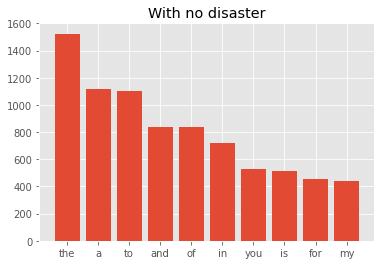

In [5]:
corpus = create_corpus(0)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)
plt.title('With no disaster')
plt.bar(x, y)

<BarContainer object of 10 artists>

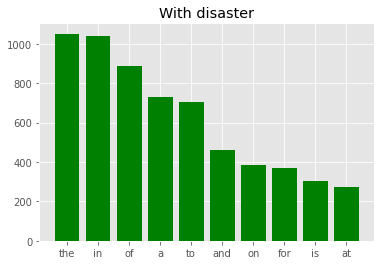

In [6]:
corpus = create_corpus(1)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)

plt.title('With disaster')
plt.bar(x, y, color='green')

<BarContainer object of 20 artists>

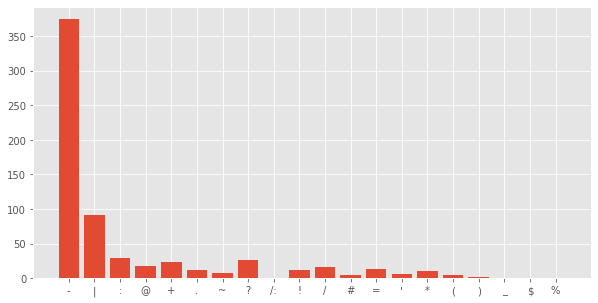

In [7]:
plt.figure(figsize=(10, 5))
corpus = create_corpus(0)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y)


<BarContainer object of 20 artists>

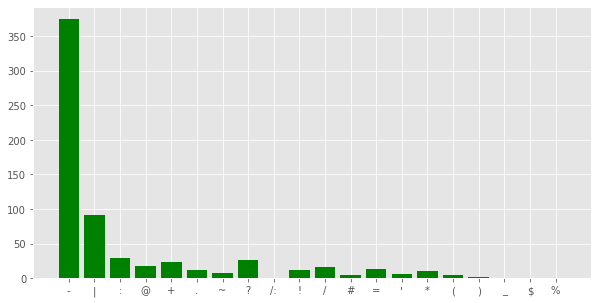

In [8]:
plt.figure(figsize=(10, 5))
corpus = create_corpus(0)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color='green')

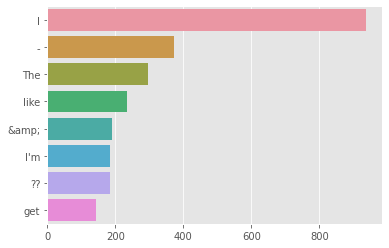

In [9]:
counter = Counter(corpus)
most_common = counter.most_common()

x = list()
y = list()

for word, count in most_common[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y, y=x, orient='h')

In [10]:
def get_top_tweet_bigrams(corpus, n=10):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

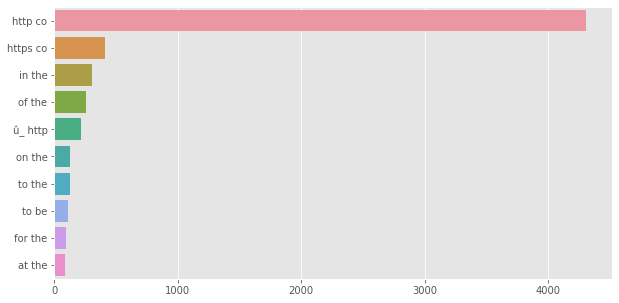

In [11]:
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]

x, y = map(list, zip(*top_tweet_bigrams))

sns.barplot(x=y, y=x)

In [12]:
df = pd.concat([train, test])
df.shape

(10876, 5)

In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub('', text)

example = 'New competition launched: https://www.kaggle.com/c/nlp-getting-started'

remove_URL(example)

'New competition launched: '

In [14]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [15]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [16]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    
    return html.sub('', text)

print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [17]:
df['text'] = df['text'].apply(lambda x: remove_html(x))

In [18]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)


remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [19]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [20]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    
    return text.translate(table)

example = "I am #king"
print(remove_punct(example))

I am king


In [21]:
df['text'] = df['text'].apply(lambda x: remove_punct(x))

In [22]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [23]:
keywords = train.keyword.unique()[1:]
keywords = list(map(lambda x: x.replace('%20', ' '), keywords))

wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    sentence_words = sentence.split(' ')
    new_sentence_words = list()
    
    for sentence_word in sentence_words:
        sentence_word = sentence_word.replace('#', '')
        new_sentence_word = wnl.lemmatize(sentence_word.lower(), wordnet.VERB)
        new_sentence_words.append(new_sentence_word)
        
    new_sentence = ' '.join(new_sentence_words)
    new_sentence = new_sentence.strip()
    
    return new_sentence

In [24]:
df['text'] = df['text'].apply(lambda x: lemmatize_sentence(x))

**PyTorch**

In [25]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

In [26]:
def prepare_csv(df_train, df_test, seed=27, val_ratio=0.3):
    idx = np.arange(df_train.shape[0])
    
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    val_size = int(len(idx) * val_ratio)
    
    if not os.path.exists('cache'):
        os.makedirs('cache')
    
    df_train.iloc[idx[val_size:], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_train.csv', index=False
    )
    
    df_train.iloc[idx[:val_size], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_val.csv', index=False
    )
    
    df_test[['id', 'text']].to_csv('cache/dataset_test.csv',
                   index=False)

In [27]:
def get_iterator(dataset, batch_size, train=True,
                 shuffle=True, repeat=False):
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                          else 'cpu')
    
    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=device,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )
    
    return dataset_iter

In [28]:
import logging
from copy import deepcopy

LOGGER = logging.getLogger('tweets_dataset')

def get_dataset(fix_length=100, lower=False, vectors=None):
    
    if vectors is not None:
        lower=True
        
    LOGGER.debug('Preparing CSV files...')
    prepare_csv(train, test)
    
    TEXT = data.Field(sequential=True, 
#                       tokenize='spacy', 
                      lower=True, 
                      include_lengths=True, 
                      batch_first=True, 
                      fix_length=25)
    LABEL = data.Field(use_vocab=True,
                       sequential=False,
                       dtype=torch.float32)
    ID = data.Field(use_vocab=False,
                    sequential=False,
                    dtype=torch.float32)
    
    
    LOGGER.debug('Reading train csv files...')
    
    train_temp, val_temp = data.TabularDataset.splits(
        path='cache/', format='csv', skip_header=True,
        train='dataset_train.csv', validation='dataset_val.csv',
        fields=[
            ('id', ID),
            ('target', LABEL),
            ('text', TEXT)
        ]
    )
    
    LOGGER.debug('Reading test csv file...')
    
    test_temp = data.TabularDataset(
        path='cache/dataset_test.csv', format='csv',
        skip_header=True,
        fields=[
            ('id', ID),
            ('text', TEXT)
        ]
    )
    
    LOGGER.debug('Building vocabulary...')
    
    TEXT.build_vocab(
        train_temp, val_temp, test_temp,
        max_size=20000,
        min_freq=10,
        vectors=GloVe(name='6B', dim=300)  # We use it for getting vocabulary of words
    )
    LABEL.build_vocab(
        train_temp
    )
    ID.build_vocab(
        train_temp, val_temp, test_temp
    )
    
    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)
    
    train_iter = get_iterator(train_temp, batch_size=32, 
                              train=True, shuffle=True,
                              repeat=False)
    val_iter = get_iterator(val_temp, batch_size=32, 
                            train=True, shuffle=True,
                            repeat=False)
    test_iter = get_iterator(test_temp, batch_size=32, 
                             train=False, shuffle=False,
                             repeat=False)
    
    
    LOGGER.debug('Done preparing the datasets')
    
    return TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter

In [29]:
TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter = get_dataset()

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399927/400000 [00:52<00:00, 7939.59it/s]

In [30]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights):
        super(LSTMClassifier, self).__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = torch.nn.Embedding(vocab_size,
                                                  embedding_dim)
        self.word_embeddings.weight = torch.nn.Parameter(weights,
                                                         requires_grad=False)
        
        self.dropout_1 = torch.nn.Dropout(0.3)
        self.lstm = torch.nn.LSTM(embedding_dim,
                                  hidden_dim,
                                  n_layers,
                                  dropout=0.3,
                                  batch_first=True)
        
        self.dropout_2 = torch.nn.Dropout(0.3)
        self.label_layer = torch.nn.Linear(hidden_dim, output_size)
        
        self.act = torch.nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        x = self.word_embeddings(x)
        
        x = self.dropout_1(x)
        
        lstm_out, hidden = self.lstm(x, hidden)
                
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout_2(lstm_out)
        out = self.label_layer(out)    
        
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1, :]

        out = self.act(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden

In [31]:
def train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size=32):
    h = model.init_hidden(batch_size)
    
    clip = 5
    val_loss_min = np.Inf
    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        
    total_val_epoch_loss = list()
    total_val_epoch_acc = list()
        
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
        
        val_epoch_loss = list()
        val_epoch_acc = list()
        
        for idx, batch in enumerate(tqdm(train_iter)):
            h = tuple([e.data for e in h])

            text = batch.text[0]
            target = batch.target
            target = target - 1
            target = target.type(torch.LongTensor)

            text = text.to(device)
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction, h = model(text, h)
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()

            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_iter)):
                val_h = tuple([e.data for e in h])

                text = batch.text[0]
                target = batch.target
                target = target - 1
                target = target.type(torch.LongTensor)
                
                text = text.to(device)
                target = target.to(device)
                
                if text.size()[0] is not batch_size:
                    continue

                prediction, h = model(text, h)
                loss_val = loss(prediction.squeeze(), target)

                num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

                acc = 100.0 * num_corrects / len(batch)

                val_epoch_loss.append(loss_val.item())
                val_epoch_acc.append(acc.item())
                
            print(f'Vadlidation Epoch: {epoch}, Training Loss: {np.mean(val_epoch_loss):.4f}, Training Accuracy: {np.mean(val_epoch_acc): .2f}%')
                
            if np.mean(val_epoch_loss) <= val_loss_min:
#                 torch.save(model.state_dict(), 'state_dict.pth')
                print('Validation loss decreased ({:.6f} --> {:.6f})'.
                      format(val_loss_min, np.mean(val_epoch_loss)))
                
                val_loss_min = np.mean(val_epoch_loss)
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        total_val_epoch_loss.append(np.mean(val_epoch_loss))
        total_val_epoch_acc.append(np.mean(val_epoch_acc))
    
    return (total_train_epoch_loss, total_train_epoch_acc,
            total_val_epoch_loss, total_val_epoch_acc)

In [39]:
lr = 1e-4
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300

model = LSTMClassifier(vocab_size=vocab_size, 
                       output_size=output_size, 
                       embedding_dim=embedding_length,
                       hidden_dim=hidden_size,
                       n_layers=2,
                       weights=word_embeddings
)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc, val_loss, val_acc = train_model(model=model,
                                                       train_iter=train_iter,
                                                       val_iter=val_iter,
                                                       optim=optim,
                                                       loss=loss,
                                                       num_epochs=15,
                                                       batch_size=batch_size)
    


Train Epoch: 0, Training Loss: 0.6799, Training Accuracy:  55.69%



Vadlidation Epoch: 0, Training Loss: 0.6478, Training Accuracy:  55.85%
Validation loss decreased (inf --> 0.647756)



Train Epoch: 1, Training Loss: 0.6190, Training Accuracy:  65.17%



Vadlidation Epoch: 1, Training Loss: 0.6052, Training Accuracy:  73.15%
Validation loss decreased (0.647756 --> 0.605157)



Train Epoch: 2, Training Loss: 0.5763, Training Accuracy:  74.81%



Vadlidation Epoch: 2, Training Loss: 0.5635, Training Accuracy:  74.34%
Validation loss decreased (0.605157 --> 0.563540)



Train Epoch: 3, Training Loss: 0.5482, Training Accuracy:  76.11%



Vadlidation Epoch: 3, Training Loss: 0.5539, Training Accuracy:  74.96%
Validation loss decreased (0.563540 --> 0.553942)



Train Epoch: 4, Training Loss: 0.5412, Training Accuracy:  76.84%



Vadlidation Epoch: 4, Training Loss: 0.5540, Training Accuracy:  74.82%



Train Epoch: 5, Training Loss: 0.5309, Training Accuracy:  77.77%



Vadlidation Epoch: 5, Training Loss: 0.5441, Training Accuracy:  76.41%
Validation loss decreased (0.553942 --> 0.544055)



Train Epoch: 6, Training Loss: 0.5292, Training Accuracy:  78.01%



Vadlidation Epoch: 6, Training Loss: 0.5470, Training Accuracy:  75.53%



Train Epoch: 7, Training Loss: 0.5277, Training Accuracy:  77.99%



Vadlidation Epoch: 7, Training Loss: 0.5447, Training Accuracy:  76.01%



Train Epoch: 8, Training Loss: 0.5210, Training Accuracy:  78.82%



Vadlidation Epoch: 8, Training Loss: 0.5423, Training Accuracy:  76.10%
Validation loss decreased (0.544055 --> 0.542329)



Train Epoch: 9, Training Loss: 0.5210, Training Accuracy:  78.37%



Vadlidation Epoch: 9, Training Loss: 0.5431, Training Accuracy:  75.75%



Train Epoch: 10, Training Loss: 0.5219, Training Accuracy:  78.43%



Vadlidation Epoch: 10, Training Loss: 0.5422, Training Accuracy:  75.84%
Validation loss decreased (0.542329 --> 0.542235)



Train Epoch: 11, Training Loss: 0.5172, Training Accuracy:  78.97%



Vadlidation Epoch: 11, Training Loss: 0.5370, Training Accuracy:  76.76%
Validation loss decreased (0.542235 --> 0.537025)



Train Epoch: 12, Training Loss: 0.5128, Training Accuracy:  79.44%



Vadlidation Epoch: 12, Training Loss: 0.5427, Training Accuracy:  75.97%



Train Epoch: 13, Training Loss: 0.5151, Training Accuracy:  78.97%



Vadlidation Epoch: 13, Training Loss: 0.5372, Training Accuracy:  76.54%



Train Epoch: 14, Training Loss: 0.5111, Training Accuracy:  79.42%



Vadlidation Epoch: 14, Training Loss: 0.5416, Training Accuracy:  76.23%


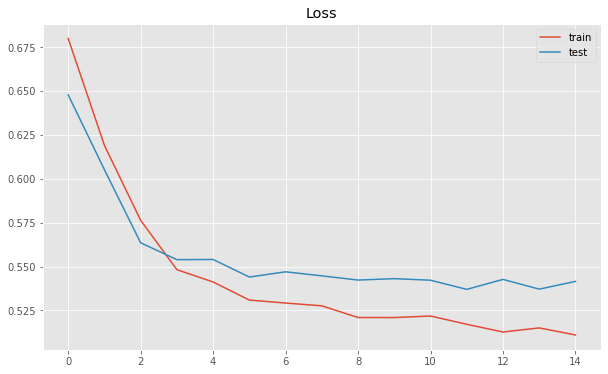

In [43]:
plt.figure(figsize=(10, 6))
plt.title('Loss')
sns.lineplot(range(len(train_loss)), train_loss, label='train')
sns.lineplot(range(len(val_loss)), val_loss, label='test')

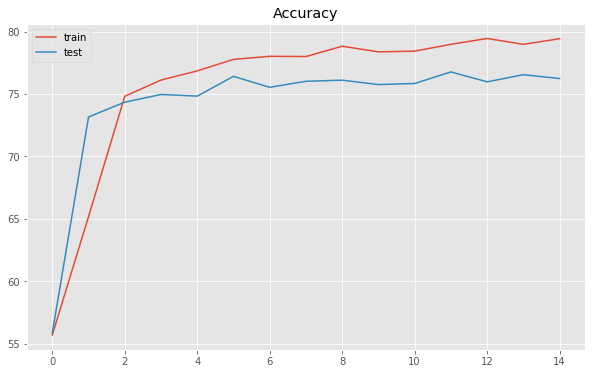

In [44]:
plt.figure(figsize=(10, 6))
plt.title('Accuracy')
sns.lineplot(range(len(train_acc)), train_acc, label='train')
sns.lineplot(range(len(val_acc)), val_acc, label='test')

In [40]:
results_target = list()

with torch.no_grad():
    for batch in tqdm(test_iter):
        for text, idx in zip(batch.text[0], batch.id):
            text = text.unsqueeze(0)
            res, _ = model(text, hidden=None)

            target = np.round(res.cpu().numpy())
            
            results_target.append(target[0][1])

In [45]:
sample_submission['target'] = list(map(int, results_target))

In [46]:
sample_submission.to_csv('29062020_18.csv', index=False)